<a href="https://colab.research.google.com/github/nealm682/Vectorizing-Many-PDFs/blob/main/ExampleForBruce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q langchain==0.0.150 pypdf pandas matplotlib tiktoken textract transformers openai faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.4/648.4 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.8/254.8 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 110.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 90.7 MB/s eta 0

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.chains import ConversationalRetrievalChain
from google.colab import files
from IPython.display import display
import ipywidgets as widgets


# Set API Key- Add your API key here
os.environ["OPENAI_API_KEY"] = ""


# Request the user to upload a file
uploaded = files.upload()

for fn in uploaded.keys():
  pdf = fn
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Convert filename syntax to be used downstream
filename = pdf.replace(' ', '-')
filename_text = filename.replace('pdf', 'txt')


Saving Fundamentals-of-Nursing_ Standards-and-Practice.pdf to Fundamentals-of-Nursing_ Standards-and-Practice.pdf
User uploaded file "Fundamentals-of-Nursing_ Standards-and-Practice.pdf" with length 65162150 bytes


In [ ]:
#Split by chunk
# Step 1: Convert PDF to text
import textract
doc = textract.process('/content/Fundamentals-of-Nursing_ Standards-and-Practice.pdf')
#doc = textract.process("./"+filename)

In [ ]:
# Step 2: Save to .txt and reopen (helps prevent issues)
with open('filename_text', 'w') as f:
    f.write(doc.decode('utf-8'))

with open('filename_text', 'r') as f:
    text = f.read()

Token indices sequence length is longer than the specified maximum sequence length for this model (1268 > 1024). Running this sequence through the model will result in indexing errors


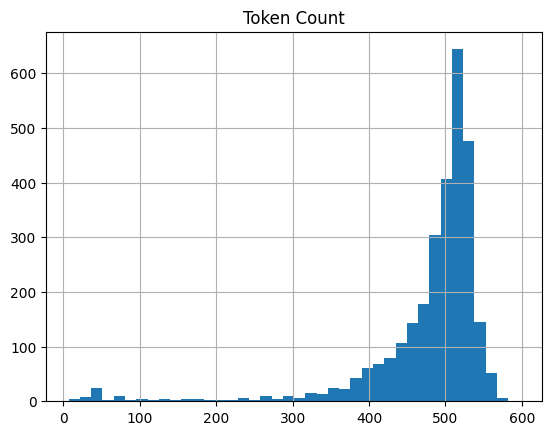

In [ ]:
# Step 3: Create function to count tokens
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

# Step 4: Split text into chunks
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 512,
    chunk_overlap  = 24,
    length_function = count_tokens,
)

chunks = text_splitter.create_documents([text])


# Quick data visualization to ensure chunking was successful
# Create a list of token counts
token_counts = [count_tokens(chunk.page_content) for chunk in chunks]

# Create a DataFrame from the token counts
df = pd.DataFrame({'Token Count': token_counts})

# Create a histogram of the token count distribution
df.hist(bins=40, )

# Show the plot
plt.show()

In [ ]:
# Get embedding model
embeddings = OpenAIEmbeddings()

# Create vector database
db = FAISS.from_documents(chunks, embeddings)


# Create conversation chain that uses our vectordb as retriver, this also allows for chat history management
qa = ConversationalRetrievalChain.from_llm(OpenAI(temperature=0.7), db.as_retriever())


chat_history = []

def on_submit(_):
    query = input_box.value
    input_box.value = ""

    if query.lower() == 'exit':
        print("Thank you for using Neal's chatbot!")
        return

    result = qa({"question": query, "chat_history": chat_history})
    chat_history.append((query, result['answer']))

    display(widgets.HTML(f'<b>User:</b> {query}'))
    display(widgets.HTML(f'<b><font color="blue">Chatbot:</font></b> {result["answer"]}'))

print("Ask me a question about the PDF document you just uploaded. Type 'exit' to stop.")

input_box = widgets.Text(placeholder='Please enter your question here:')
input_box.on_submit(on_submit)

display(input_box)

Ask me a question about the PDF document you just uploaded. Type 'exit' to stop.


Text(value='', placeholder='Please enter your question here:')

HTML(value='<b>User:</b> list the guidelines for using aromatherapy')

HTML(value='<b><font color="blue">Chatbot:</font></b>  (cid:129) Always dilute essential oils in a carrier oil…

HTML(value='<b>User:</b> what is the importance of blood pressure cuff')

HTML(value='<b><font color="blue">Chatbot:</font></b>  A blood pressure cuff is important because it ensures e…

HTML(value='<b>User:</b> Applying a Condom Catheter')

HTML(value='<b><font color="blue">Chatbot:</font></b>  The condom catheter is a device used to contain urine i…

HTML(value='<b>User:</b> what are the action steps applying a Condom Catheter')

HTML(value='<b><font color="blue">Chatbot:</font></b>  1. Apply latex-free gloves. 2. Pull the sheet up over t…